# Identifying Threshold

**This is an archived file**

This notebook was used to calculate a threshold value for steady state (in other words, the point at which the phase derivative reaches its steady state point). This is how we know our sensor chamber has been completely purged of moisture, and serves as a baseline point which we use to compare different compounds.

##### Grab the CSV file you want to analyze

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter as sgf
from math import factorial as fact

df = pd.read_csv("../Scan CSV Files/14.csv")
df.drop("Unnamed: 0", axis = 1, inplace=True)
df.set_index("Wavelengths", inplace=True)
df.head()

,0,1.01,2.02,3.02,4.03,5.04,6.05,7.06,8.06,9.07,...,810.71,810.82,810.93,811.04,811.15,811.27,811.38,811.49,811.6,811.71
Wavelengths,,,,,,,,,,,,,,,,,,,,,
340.191309,18.3498,18.3498,18.3498,18.3498,18.3498,18.3498,18.3498,18.3498,18.3498,18.3498,...,18.3498,18.3498,18.3498,18.3498,18.3498,18.3498,18.3498,18.3498,18.3498,18.3498
340.562061,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736,...,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736,29946.8736
340.932784,838.8480,775.9344,857.1978,783.7986,841.4694,773.3130,799.5270,762.8274,794.2842,815.2554,...,781.1772,796.9056,791.6628,760.2060,762.8274,799.5270,768.0702,796.9056,815.2554,728.7492
341.303478,728.7492,686.8068,731.3706,741.8562,741.8562,736.6134,726.1278,741.8562,754.9632,702.5352,...,713.0208,694.6710,689.4282,720.8850,705.1566,733.9920,650.1072,754.9632,715.6422,778.5558
341.674143,697.2924,707.7780,676.3212,652.7286,744.4776,694.6710,692.0496,804.7698,707.7780,747.0990,...,697.2924,731.3706,713.0208,744.4776,718.2636,697.2924,710.3994,720.8850,694.6710,689.4282


### Calculating the threshold value for steady state

In [32]:
# Absolute difference between reference scans
diff = [] # List with the SAD

# Calculating the differences
first = list(df[df.columns[0]]) # Compare with first spectrum
for i in df.columns:
    compare = list(df[i])
    diff.append(sum([abs(i-j) for i,j in zip(first, compare)]))

# Calculates best window length for smoothing function
def N_opt(diff, L = len(diff), n=3):
    n = 3
    term1 = (2*(n+2) * (fact(2*n+3))**2)/(fact(n+1))**2

    vn = 1/L * sum(np.diff(diff,n+2)**2)
    var = np.var(diff)**2

    Nopt = (term1*var/vn)**(1/(2*n+5))
    
    return int(np.ceil(Nopt) // 2 * 2 + 1)

# Spectrum for calculating threshold
diff = sgf(diff, window_length=N_opt(diff), polyorder=3)

# gives the incremental difference between data points
change = [i - j for i,j in zip(diff[:-2], diff[1:])]
change = sgf(change, window_length=301, polyorder=3)
sec_deriv = sgf(change, window_length=101, polyorder=3, deriv=2)

# Finds steady state value, where value of second derivative stays within 0.2 over 60 time steps
def steady_state(seq, n=60, eps=0.2):
    seq = abs(seq) < eps
    for i in range(len(seq)):
        win = seq[i:i+n]
        if sum(win) == n:
            return int(i+n/2), i
    return "Never reached steady state"
        
threshold = steady_state(sec_deriv)

### Plotting values

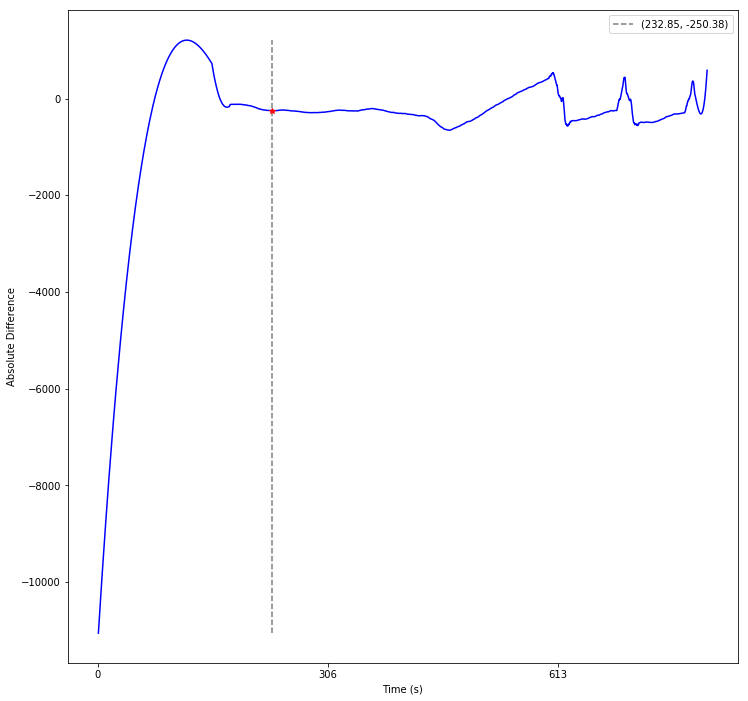

In [8]:
%matplotlib inline

curr_plot = change

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, ylabel="Absolute Difference", xlabel="Time (s)")
ax.set_xticks([float(df.columns[i])*2 for i in range(len(df.columns)) if i%int(len(df.columns)/10) == 0])

dfcols = [float(i) for i in df.columns[1:threshold]] + [float(i) for i in df.columns[threshold+1:-1]]
ax.plot(dfcols, np.concatenate((curr_plot[:threshold], curr_plot[threshold+1:])), 'b-')
ax.plot(float(df.columns[threshold]), curr_plot[threshold], 'r*')

# plt.axvspan(0,float(df.columns[threshold]), color="y", alpha=0.2)
# plt.axhspan(min(curr_plot),curr_plot[threshold], color="b", alpha=0.2)
plt.vlines(float(df.columns[threshold]),min(curr_plot), max(curr_plot), alpha=0.5, linestyles={'dashed'}, label='{}'
           .format((float(df.columns[threshold]), round(curr_plot[threshold],2))))
plt.legend()

1521
1521 1520


(1521, 1521)

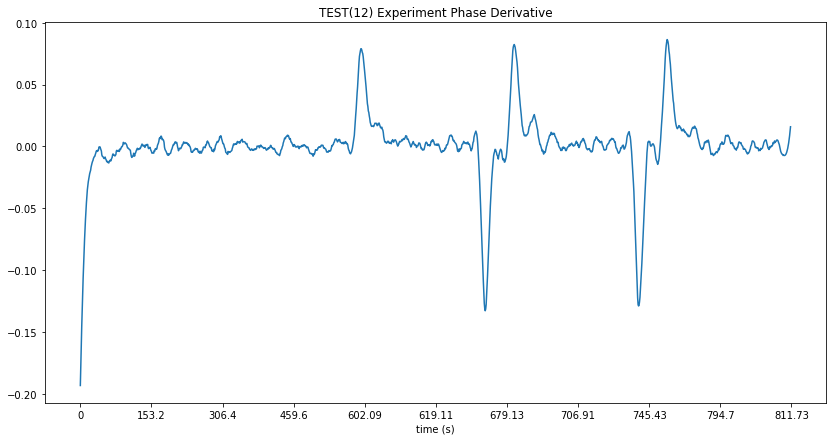

In [108]:
import pandas as pd

# Read file and convert it to pandas dataframe
compound = "TEST"
exp_name = 12
purge = 600

df = pd.read_csv("../Scan CSV Files/{}.csv".format(exp_name))
df.drop("Unnamed: 0", axis=1, inplace=True)
df.set_index("Wavelengths", inplace=True)
exp_name = compound + "({})".format(exp_name)

sliced = [df.index[500], df.index[1200]] # Wavelengths between 400 and 900

# taking the transpose means you get the fourier transform with time axis
ft_data = np.fft.fft( (df.loc[sliced[0]:sliced[1], :]).transpose() ) 

R = np.real(ft_data[:, 1])
I = np.imag(ft_data[:, 1])

# Calculating Phase
phase = I / (R ** 2 + I ** 2) ** 0.5
phase = sgf(phase, window_length=31, polyorder=3)

# Normalization
phase = phase/np.sqrt(np.sum(phase**2))
phase_deriv = np.diff(phase)
phase_deriv = sgf(phase_deriv, window_length=31, polyorder=3)

# Normalization
phase_deriv = phase_deriv/np.sqrt(np.sum(phase_deriv**2))

# Plotting
fig = plt.figure(figsize=(14,7))
pder = fig.add_subplot(111, title="{} Experiment Phase Derivative".format(exp_name), xlabel="time (s)")

pder.plot(phase_deriv)

pder.set_xticks(np.linspace(0, len(df.columns), 11))
pder.set_xticklabels([df.columns[i] for i in range(len(df.columns)) if i%int(len(df.columns)/10) == 0])


ss_pd = phase_deriv[:purge-20] # Use only up until first odorant is injected

eps = min([np.mean(ss_pd) + np.std(ss_pd), np.mean(ss_pd) + np.std(ss_pd)])/2

threshold = steady_state(phase_deriv, eps = eps)[0]
threshold_i = steady_state(phase_deriv, eps = eps)[1]

threshold, threshold_i

Index(['601.3', '691.68', '782.05'], dtype='object')


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

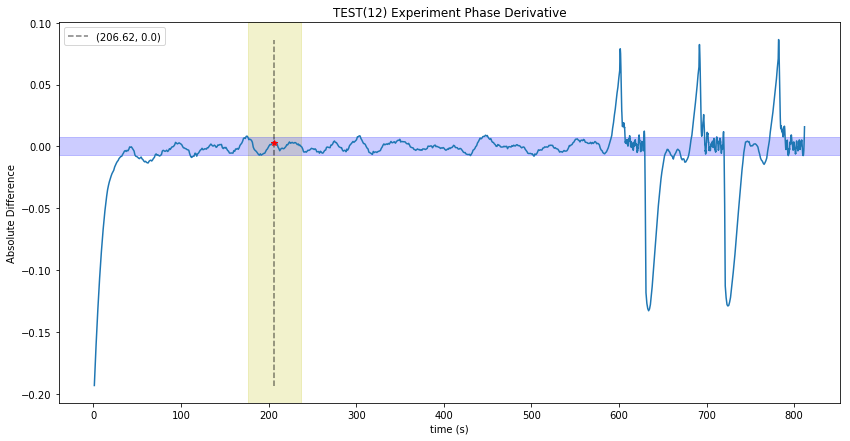

In [85]:
curr_plot = phase_deriv

fig = plt.figure(figsize=(14, 7))
pder = fig.add_subplot(111, title="{} Experiment Phase Derivative".format(exp_name), xlabel="time (s)", ylabel="Absolute Difference")


dfcols = [float(i) for i in df.columns[1:threshold]] + [float(i) for i in df.columns[threshold+1:]]
pder.plot(dfcols, np.concatenate((curr_plot[:threshold], curr_plot[threshold+1:])))
pder.plot(float(df.columns[threshold]), curr_plot[threshold], 'r*')

plt.axvspan(float(df.columns[threshold-30]),float(df.columns[threshold+30]), color="y", alpha=0.2)
plt.axhspan(-eps,eps, color="b", alpha=0.2)
plt.vlines(float(df.columns[threshold]),min(curr_plot), max(curr_plot), alpha=0.5, linestyles={'dashed'}, label='{}'
           .format((float(df.columns[threshold]), round(curr_plot[threshold],2))))
plt.legend()



Finding peaks

0.031571367540714095
[601, 928, 1255]
[0.07897, 0.08238, 0.08639]
[866, 1194]
[0.13292, 0.12905]


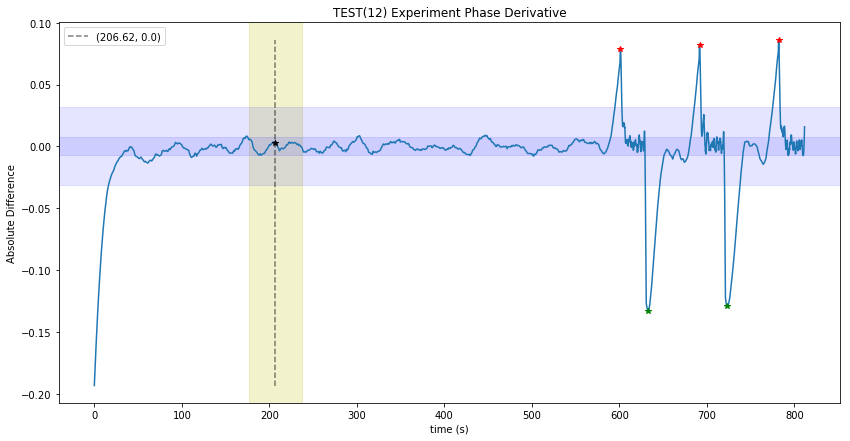

In [161]:
from scipy.signal import find_peaks as peaks

ss_pd2 = phase_deriv[purge-20:] # Use only up until first odorant is injected
eps2 = max([np.mean(ss_pd2) + np.std(ss_pd2), np.mean(ss_pd2) + np.std(ss_pd2)])
print(eps2)

peak_list = list(peaks(phase_deriv, eps2))[0]
print([i for i in peak_list])

peak_height = peaks(phase_deriv, eps2)[1]['peak_heights']
print([round(i,5) for i in peak_height])

trough_list = list(peaks(-phase_deriv, eps2))[0]
print([i for i in trough_list])

trough_height = peaks(-phase_deriv, eps*5)[1]['peak_heights']
print([round(i,5) for i in trough_height])


curr_plot = phase_deriv

fig = plt.figure(figsize=(14, 7))
pder = fig.add_subplot(111, title="{} Experiment Phase Derivative".format(exp_name), xlabel="time (s)", ylabel="Absolute Difference")


dfcols = [float(i) for i in df.columns[:-1]]
pder.plot(dfcols, curr_plot)
for i in peak_list: 
    pder.plot(float(df.columns[i]), curr_plot[i], 'r*')
for i in trough_list:
    pder.plot(float(df.columns[i]), curr_plot[i], 'g*')
pder.plot(float(df.columns[threshold]), curr_plot[threshold], 'k*')
    
plt.axvspan(float(df.columns[threshold-30]),float(df.columns[threshold+30]), color="y", alpha=0.2)
plt.axhspan(-eps,eps, color="b", alpha=0.1)
plt.axhspan(-eps2,eps2, color="b", alpha=0.1)
plt.vlines(float(df.columns[threshold]),min(curr_plot), max(curr_plot), alpha=0.5, linestyles={'dashed'}, label='{}'
           .format((float(df.columns[threshold]), round(curr_plot[threshold],2))))
plt.legend()

